## Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


## Load data

In [2]:
df_ks = pd.read_csv('KS_train_data.csv', delimiter= ',')
data_ks_to_predict = pd.read_csv('KS_test_data.csv', delimiter= ';')

## Derive features

### Goal related feature

In [3]:
df_ks['usd_goal'] = df_ks['goal'] * df_ks['fx_rate']

In [4]:
data_ks_to_predict['usd_goal'] = data_ks_to_predict['goal'] * data_ks_to_predict['fx_rate']

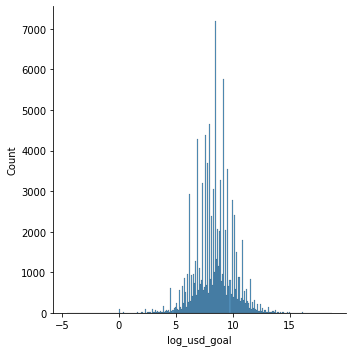

In [5]:
df_ks['log_usd_goal'] = np.log(df_ks['usd_goal'])

sns.displot(df_ks['log_usd_goal'])

### Promotion duration

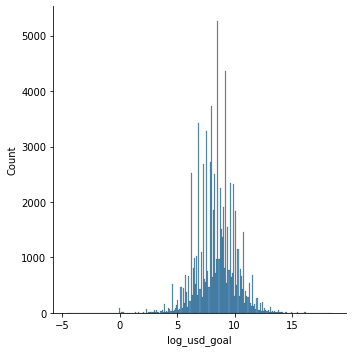

In [6]:
data_ks_to_predict['log_usd_goal'] = np.log(data_ks_to_predict['usd_goal'])

sns.displot(data_ks_to_predict['log_usd_goal'])

In [5]:
duration = pd.to_datetime(df_ks['deadline'], unit='s') - pd.to_datetime(df_ks['launched_at'], unit='s')
df_ks['promotion_duration'] = duration / np.timedelta64(1, 'D')

count    100000.000000
mean         33.840738
std          12.953758
min           1.000000
25%          30.000000
50%          30.000000
75%          36.000000
max          91.958333
Name: promotion_duration, dtype: float64

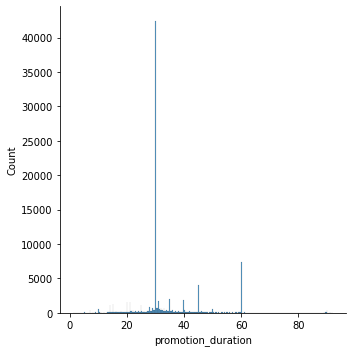

In [6]:
sns.displot(df_ks['promotion_duration'])
df_ks['promotion_duration'].describe()

In [7]:
top_10 = df_ks['promotion_duration'].value_counts()[:10].index
print(top_10)

Float64Index([              30.0,               60.0, 29.958333333333332,
              30.041666666666668,               45.0,               40.0,
                            35.0, 60.041666666666664,               20.0,
              59.958333333333336,               21.0,               15.0,
                            25.0,               31.0,               14.0,
                            28.0, 44.958333333333336,               10.0],
             dtype='float64')


### Encode country and category

In [7]:
from sklearn import preprocessing

#creating labelEncoder
le = preprocessing.LabelEncoder()

In [9]:
# Converting string labels into numbers.
df_ks['country_encoded'] = le.fit_transform(df_ks['country'])

# print(df_ks['country_encoded'] )

In [8]:
df_ks['category_encoded'] = le.fit_transform(df_ks['category'])

#print(df_ks['category_encoded'])

### One-hot Encoding

In [9]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

enc_category = pd.DataFrame(enc.fit_transform(df_ks[['category']]).toarray())

In [10]:
enc_pred_category = pd.DataFrame(enc.fit_transform(data_ks_to_predict[['category']]).toarray())

In [11]:
df_ks = df_ks.join(enc_category)

In [12]:
data_ks_to_predict = data_ks_to_predict.join(enc_pred_category)

## Model Training

### Choose features

In [13]:

# No. 1
# Random Forest（Train：0.89， Test：0.69 ） Obviously Overfit
# KNN（Train：0.70， Test：0.69）
#features = ['log_usd_goal','promotion_duration','country_encoded','category_encoded','staff_pick']

# No. 11
# Random Forest（Train：0.78， Test：0.70 ）Overfit is mainly due to promotion_duration
#features = ['log_usd_goal','country_encoded','category_encoded','staff_pick']

# No. 2
# without country 
# KNN （Train: 0.71, Test: 0.7)
# Random Forest（Train：0.88， Test：0.69）still overfit
#features = ['log_usd_goal','promotion_duration','category_encoded','staff_pick']

# No. 9 (Final Random Forest Features)
# without promotion_duration
# Random Forest（Train：0.764， Test：0.7006）
#features = ['log_usd_goal','category_encoded','staff_pick']

# No. 3 
# without category but have country (test score decreases, category affects the prediced result)
# KNN （Train：0.68， Test：0.67）
# Random Forest (Train：0.83， Test：0.67)
#features = ['log_usd_goal','promotion_duration','country_encoded','staff_pick']

# No. 4
# Categorical Features Only (High bias => numerical features matter)
# KNN （Train：0.675， Test: 0.66）
# Random Forest (Train : 0.68, Test: 0.66)
#features = ['country_encoded','category_encoded','staff_pick']

# No. 5
# Continuous Numerical Features Only
# KNN （Train：0.659， Test: 0.6521）
# Random Forest (Train : 0.79, Test: 0.63) Overfit
#features = ['log_usd_goal','promotion_duration']

# No. 6
# replace category_encoded to one-hot encoded
# KNN （Train：0.690， Test: 0.678）
# Random Forest (Train : 0.868, Test: 0.658)
#features = ['log_usd_goal','promotion_duration',0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14]

# No. 7
#Discrete numerical features only (underfit)
# KNN （Train：0.651， Test: 0.6499）
# Random Forest (Train : 0.667, Test: 0.667)
#features = ['staff_pick',0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14]

# No. 8
# KNN （Train：0.719， Test: 0.7064）
# Random Forest (Train : 0.8857, Test: 0.6941)
#features = ['log_usd_goal','promotion_duration','staff_pick',0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14]

# No. 10 : Final KNN features
# KNN （Train：0.710， Test: 0.7037）
features = ['log_usd_goal','staff_pick',0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14]

X = df_ks[features]
y = df_ks['funded']

### Split dataset

#### One-fold

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

### KNN

#### Validation Curve

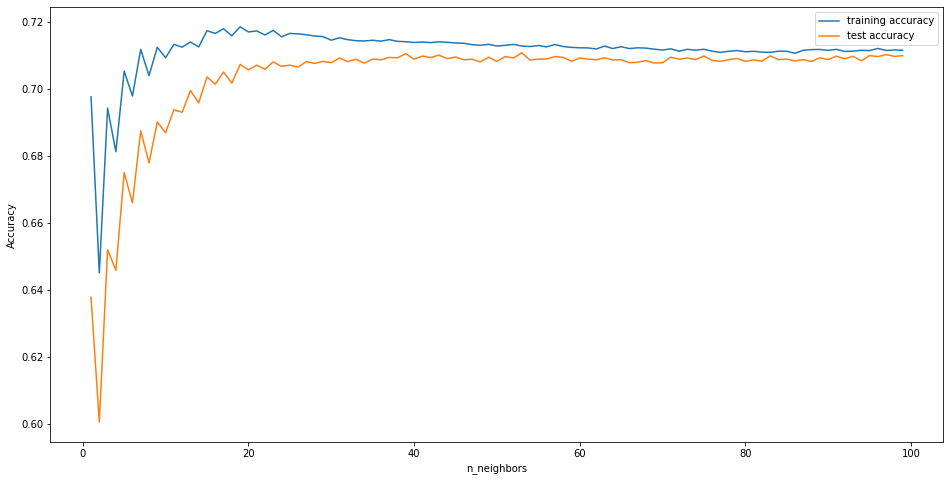

In [17]:
# No. 10 features
from sklearn.neighbors import KNeighborsClassifier
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 100)
for n_neighbors in neighbors_settings:
 # build the model
 clf = KNeighborsClassifier(n_neighbors=n_neighbors)
 clf.fit(X_train, y_train)
 # record training set accuracy
 training_accuracy.append(clf.score(X_train, y_train))
 # record generalization accuracy
 test_accuracy.append(clf.score(X_test, y_test))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=100)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=100)

In [24]:
#No.10 features

print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))

0.7113142857142857
0.7043666666666667


#### Cross-validation

In [25]:
# No. 10 features

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=100)

scores = cross_val_score(knn, X, y, cv = 200)
print(scores.mean())

0.69595


### Random Forests

In [32]:
#Random forest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8)
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.5,
                  n_estimators=100)

In [33]:
# No. 9 features
print(bag.score(X_train, y_train))
print(bag.score(X_test, y_test))

0.7702428571428571
0.7062


#### RF Cross-validation

In [34]:
# No. 9 features
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()

bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8)

scores_RF = cross_val_score(bag, X, y, cv = 20)
print(scores_RF.mean())

0.6504900000000001


## Prediction

#### fit model

In [ ]:
features = ['log_usd_goal','staff_pick',0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14]

X = df_ks[features]
y = df_ks['funded']

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=100)

knn.fit(X, y)

#### Predict

In [ ]:
data_test = data_ks_to_predict[features]

data_ks_to_predict['prediction'] = knn.predict(data_test)

#### Export

df_res = pd.DataFrame(data_ks_to_predict, columns = ['project_id', 'prediction'])

df_res.to_csv('predictions.tsv', columns=['project_id','prediction'])